## Dataset Descrição

O dataset escolhido é o [Electric Power Consumption Dataset](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set) do Kaggle, que contém dados de consumo de energia elétrica. O dataset foi registrado entre dezembro de 2006 e novembro de 2010.

### Colunas do Dataset:
- **Date**: A data no formato dd/mm/yyyy.
- **Time**: O tempo em hh:mm:ss.
- **Global_active_power**: Potência ativa global em kilowatts.
- **Global_reactive_power**: Potência reativa global em kilowatts.
- **Voltage**: Tensão média por minuto.
- **Global_intensity**: Intensidade da corrente global média por minuto.
- **Sub_metering_1**: Energia submedida para a cozinha.
- **Sub_metering_2**: Energia submedida para lavanderia.
- **Sub_metering_3**: Energia submedida para aquecimento e ar condicionado.

Essas colunas descrevem características importantes do consumo de energia em residências, sendo o **Global_active_power** o alvo de predição para este modelo de série temporal.


## Justificativa da Métrica

Para a avaliação do modelo, utilizamos o **Mean Squared Error (MSE)**. O MSE é uma métrica apropriada para este problema de regressão porque penaliza diferenças maiores entre os valores reais e preditos, o que é útil para capturar a qualidade da predição de valores contínuos, como o consumo de energia. A escolha do MSE permite uma análise detalhada do erro quadrático, que destaca grandes desvios nos resultados de predição.


# Prevendo Consumo de Energia com RNN
Este notebook utiliza uma Rede Neural Recorrente (RNN) para prever o consumo de energia com base em dados históricos.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_percentage_error


## Carregando e Visualizando os Dados
Os dados serão carregados diretamente do Google Drive para facilitar a manipulação no Google Colab.

In [13]:
from google.colab import drive
import pandas as pd

# Montar o Google Drive no Colab
drive.mount('/content/drive')

# Caminho para o dataset no Google Drive
data_path = '/content/drive/MyDrive/cc_11/ponderadas programacao/dataset/household_power_consumption.txt'

# Carregar o dataset
df = pd.read_csv(data_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True, low_memory=False, na_values=['nan', '?'], index_col='datetime')

# Exibir as primeiras linhas para verificar se o carregamento foi bem-sucedido
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-13-ddddc67c8475>:11: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(data_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
<ipython-input-13-ddddc67c8475>:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(data_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Pré-processamento dos Dados
Aqui realizamos o tratamento de valores nulos e a normalização dos dados para que o modelo RNN possa ser treinado adequadamente.

In [18]:
# Filtrando o dataset para uma janela de tempo
df = df['2007-02-01':'2007-02-02']

# Preencher valores nulos com a média
df.fillna(df.mean(), inplace=True)

# Selecionar a coluna target e normalizar os dados
target_column = 'Global_active_power'
scaler = MinMaxScaler(feature_range=(0, 1))
df[target_column] = scaler.fit_transform(df[[target_column]])
df.head()

<ipython-input-18-60d36ada6114>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)
<ipython-input-18-60d36ada6114>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_column] = scaler.fit_transform(df[[target_column]])


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2007-02-01 00:00:00,0.014597,0.128,243.15,1.4,0.0,0.0,0.0
2007-02-01 00:01:00,0.014597,0.130,243.32,1.4,0.0,0.0,0.0
2007-02-01 00:02:00,0.014321,0.132,243.51,1.4,0.0,0.0,0.0
2007-02-01 00:03:00,0.014321,0.134,243.90,1.4,0.0,0.0,0.0
2007-02-01 00:04:00,0.014046,0.130,243.16,1.4,0.0,0.0,0.0


## Criando Janelas de Tempo para a RNN
A criação de janelas de tempo ajuda a alimentar o modelo com sequências de dados que representam o histórico.

In [19]:
# Criar janelas de tempo (sequências de dados)
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data[i+window_size])
    return np.array(sequences), np.array(labels)

# Definir janela de tempo
window_size = 60
sequences, labels = create_sequences(df[target_column].values, window_size)

## Dividindo os Dados em Treino e Teste
Separar os dados em conjunto de treino e teste é essencial para avaliar o desempenho do modelo.

In [20]:
# Dividir os dados em treino e teste
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]


## Construção e Treinamento do Modelo RNN
Usamos uma arquitetura de RNN simples para realizar a predição do consumo de energia.

In [21]:
# Criar e treinar o modelo RNN
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0198 - val_loss: 0.0016
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0010 - val_loss: 7.8549e-04
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.0062e-04 - val_loss: 8.0034e-04
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.1703e-04 - val_loss: 7.5262e-04
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.8497e-04 - val_loss: 7.1477e-04
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 6.4063e-04
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.1879e-04 - val_loss: 6.7503e-04
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4439e-04 - val_loss: 6.4312e-04


## Avaliação do Modelo
Agora vamos prever os valores no conjunto de teste e avaliar o desempenho usando a métrica MAPE (Mean Absolute Percentage Error).

In [9]:
# Avaliar o modelo e calcular a métrica MAPE
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
MAPE: 0.22429280931216972


## Visualizando os Resultados
Por fim, vamos comparar os valores reais e preditos em um gráfico.

## Explicação dos Eixos do Gráfico

No gráfico apresentado, os valores reais e preditos são comparados visualmente para entender o desempenho do modelo.

- **Eixo X (Horizontal)**: Representa os instantes de tempo, ou seja, cada ponto do eixo X é uma observação temporal do dataset, indexado em sequência de acordo com os dados fornecidos.
- **Eixo Y (Vertical)**: Mostra os valores de **Global_active_power** em kilowatts, que são os valores reais e preditos pelo modelo RNN.

A linha com o label 'Valores Reais' indica os valores reais do consumo de energia, enquanto a linha com o label 'Valores Preditos' indica os valores estimados pelo modelo.


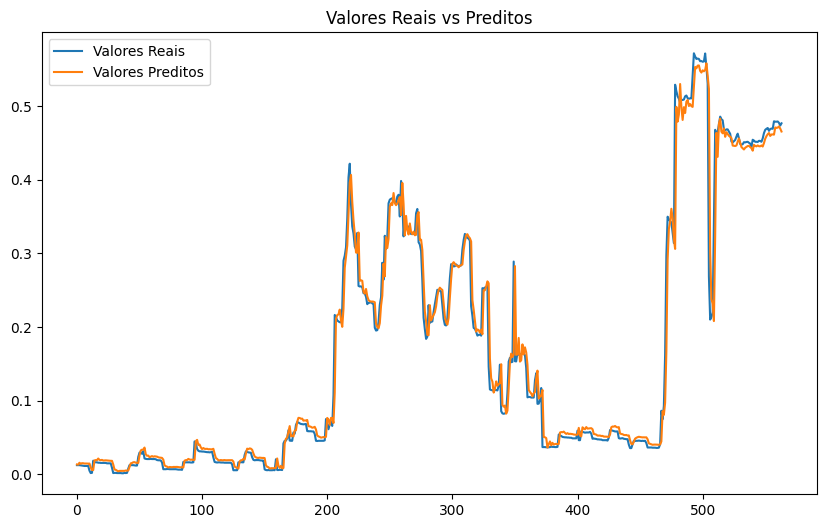

In [10]:
# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reais')
plt.plot(y_pred, label='Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.legend()
plt.show()